### Comparison of results for electronics 
Baselines
1. ~~Association Analysis (baseline; cannot work with completely unsee pairs)~~
2. MF (binary, baseline; 43.1 minutes)
3. MF-bias (binary, baseline; 44.9 minutes)  
4. MF (Continuous, baseline; 44.27 minutes) 
5. MF-bias (Continuous, baseline; 43.7 minutes)  

Sequence-based
6. ~~Node2Vec (Memory error)~~
7. Gensim word2vec (2.58 minutes)
8. PyTorch word2vec (23.63 minutes)
9. PyTorch word2vec with side information (107.66 minutes)
10. PyTorch MF (68.5 minutes)
11. PyTorch MF-bias (70.39 minutes)

### Comparison of results for books
Baselines
1. ~~Association Analysis~~
2. ~~MF (baseline)~~
3. MF-bias (baseline, 1,353.12 minutes)  
4. MF-bias (Continuous, baseline, 1,352.86 minutes) 

Sequence-based
5. ~~Node2Vec~~
6. Gensim word2vec (16.24 minutes)
7. PyTorch word2vec (122.66 minutes)
8. ~~PyTorch word2vec with side information~~ (since it doesn't work)
9. ~~PyTorch MF~~
10. PyTorch MF-bias (1,393.08 minutes)

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from collections import OrderedDict

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics import recall_score, precision_score, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import torch

from src.ml.skipgram import SkipGram
from src.ml.mf import MF
from src.ml.mf_bias import MFBias
from src.ml.mf_continuous import MFContinuous
from src.ml.mf_bias_continuous import MFBiasContinuous
from src.viz.prep_results import get_product_id
from src.viz.plot_results import plot_auc, plot_roc, plot_tradeoff, plot_metrics
from src.utils.io_utils import load_model
from src.utils.logger import logger

In [3]:
dset = 'books'

### Import validation data

In [4]:
val = pd.read_csv('../results/{}_edges_val.csv'.format(dset))

In [5]:
val.rename(columns={'weight': 'edge'}, inplace=True)

In [6]:
val.head()

,product1,product2,edge
0,0076602915,0078908353,1
1,0393920313,1111528128,1
2,0226305023,0231119577,1
3,1465017984,B0017ODENI,1
4,047063751X,1617160857,1


In [7]:
val['edge'].value_counts()

1    8776959
0    8776959
Name: edge, dtype: int64

In [8]:
val['products'] = list(zip(val['product1'], val['product2']))

### 3. MF-bias (binary, baseline)

In [9]:
word2id_edge_mf_bias = load_model('../results/word2id_torch_mf_bias_{}'.format(dset))
func = get_product_id(word2id_edge_mf_bias)
word2id_func = np.vectorize(func)

2019-12-18 09:15:12,070 - Model loaded from: ../results/word2id_torch_mf_bias_books (Size: 253394362 bytes)


In [10]:
mf = MFBias(len(word2id_edge_mf_bias), 128)
mf.load_state_dict(torch.load('../results/mf_bias_edges_epoch_4_2019-12-17-0052.pt', map_location=torch.device('cpu')))

2019-12-18 09:15:13,912 - Model initialized: MFBias(
  (product_embedding): Embedding(1948370, 128)
  (sig): Sigmoid()
  (product_bias): Embedding(1948370, 1)
  (bce): BCELoss()
)


<All keys matched successfully>

In [11]:
val['product1id_mf_bias_edge'] = word2id_func(val['product1'].values)
val['product2id_mf_bias_edge'] = word2id_func(val['product2'].values)

In [12]:
product1 = torch.LongTensor(val['product1id_mf_bias_edge'])
product2 = torch.LongTensor(val['product2id_mf_bias_edge'])
with torch.no_grad():
    val['mf_bias_score'] = mf.forward(product1, product2)

In [13]:
roc_score = roc_auc_score(val['edge'], val['mf_bias_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-18 09:18:26,219 - AUC-ROC: 0.4996054146643119


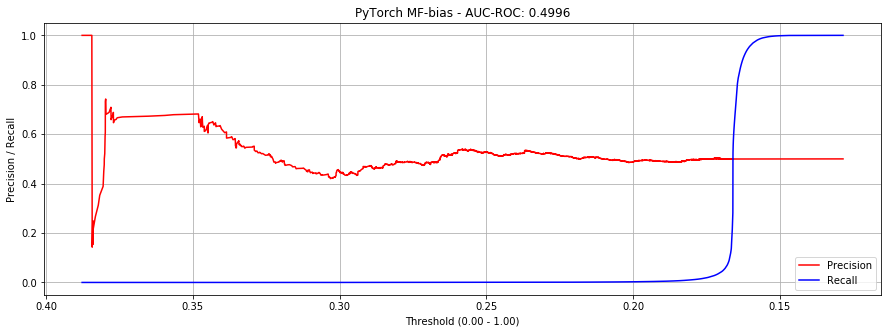

In [14]:
plot_auc(val['edge'], val['mf_bias_score'], 'PyTorch MF-bias - AUC-ROC: {:.4f}'.format(roc_score))

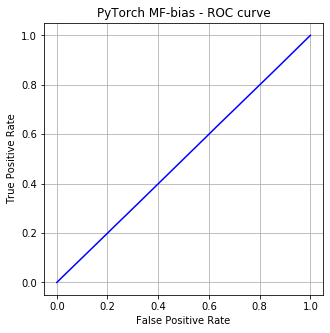

In [15]:
plot_roc(val['edge'], val['mf_bias_score'], 'PyTorch MF-bias - ROC curve')

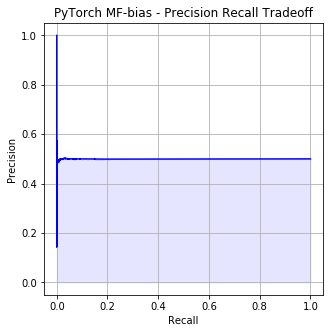

In [16]:
plot_tradeoff(val['edge'], val['mf_bias_score'], 'PyTorch MF-bias - Precision Recall Tradeoff')

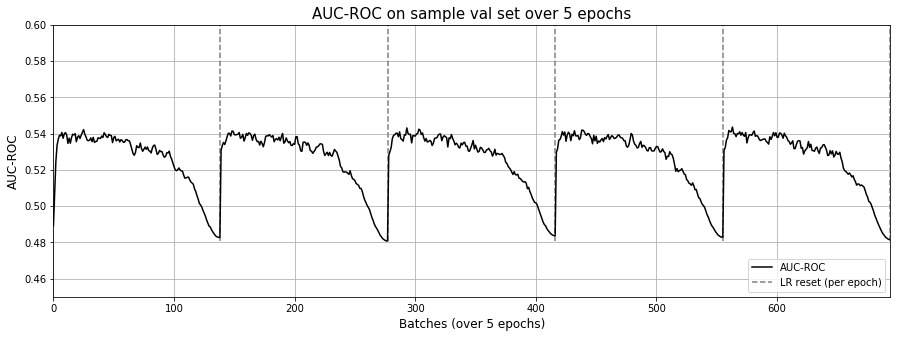

In [17]:
# Import and plot metrics
mf_bias_edge_df = pd.read_csv('../results/model_metrics_mf_bias_edges_books.csv')
plot_metrics(mf_bias_edge_df, ylim=(0.45, 0.6))

### 5. MF-bias (Continuous, baseline)

In [18]:
word2id_edge_mf_bias_cont = load_model('../results/word2id_edge_mf_bias_continuous_{}'.format(dset))
func = get_product_id(word2id_edge_mf_bias_cont)
word2id_func = np.vectorize(func)

2019-12-18 09:18:47,415 - Model loaded from: ../results/word2id_edge_mf_bias_continuous_books (Size: 253394362 bytes)


In [19]:
mf = MFBiasContinuous(len(word2id_edge_mf_bias_cont), 128)
mf.load_state_dict(torch.load('../results/mf_bias_continuous_edges_epoch_4_2019-12-17-2343.pt', map_location=torch.device('cpu')))

2019-12-18 09:18:49,163 - Model initialized: MFBiasContinuous(
  (product_embedding): Embedding(1948370, 128)
  (sig): Sigmoid()
  (product_bias): Embedding(1948370, 1)
  (mse): MSELoss()
)


<All keys matched successfully>

In [20]:
val['product1id_mf_bias_cont_edge'] = word2id_func(val['product1'].values)
val['product2id_mf_bias_cont_edge'] = word2id_func(val['product2'].values)

In [21]:
product1 = torch.LongTensor(val['product1id_mf_bias_cont_edge'])
product2 = torch.LongTensor(val['product2id_mf_bias_cont_edge'])
with torch.no_grad():
    val['mf_bias_cont_score'] = mf.predict(product1, product2)

In [22]:
roc_score = roc_auc_score(val['edge'], val['mf_bias_cont_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-18 09:22:31,977 - AUC-ROC: 0.38224596766369034


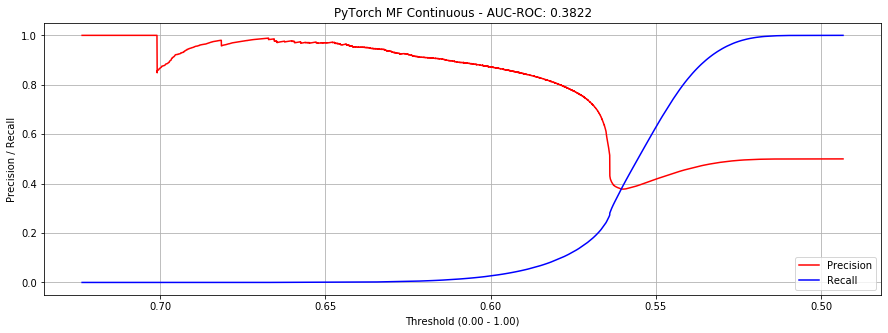

In [23]:
plot_auc(val['edge'], val['mf_bias_cont_score'], 'PyTorch MF Continuous - AUC-ROC: {:.4f}'.format(roc_score))

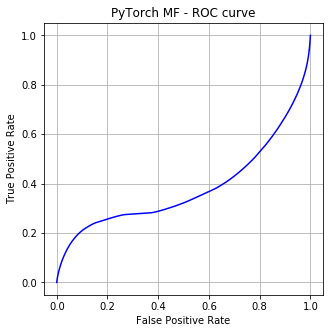

In [24]:
plot_roc(val['edge'], val['mf_bias_cont_score'], 'PyTorch MF - ROC curve')

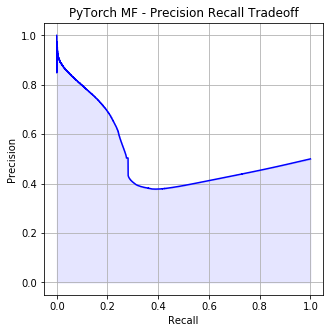

In [25]:
plot_tradeoff(val['edge'], val['mf_bias_cont_score'], 'PyTorch MF - Precision Recall Tradeoff')

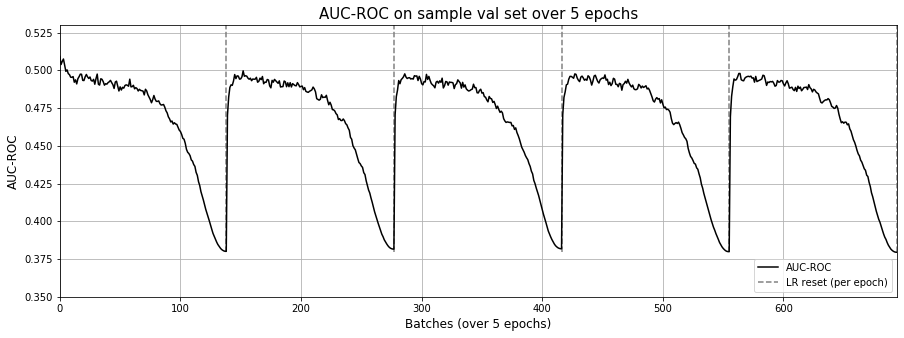

In [26]:
# Import and plot metrics
mf_bias_cont_edge_df = pd.read_csv('../results/model_metrics_mf_bias_continuous_edges_books.csv')
plot_metrics(mf_bias_cont_edge_df, ylim=(0.35, 0.53))

### 7. Gensim word2vec (16.24 minutes)

In [27]:
# Import model
kv = KeyedVectors.load('../results/gensim-w2v-2019-12-13-0643.kv')

In [28]:
def get_kv_similarity(products):
    try:
        return kv.similarity(products[0], products[1])
    except KeyError:
        return -1
    
get_kv_sim_func = np.vectorize(get_kv_similarity)

In [29]:
val['gensim_score'] = get_kv_sim_func(val['products'].values)

In [30]:
# Set score of unseen item pairs to median score of seen item pairs
val_seen = val[val['gensim_score'] != -1]
median_score = np.median(val_seen['gensim_score'])
val['gensim_score'] = np.where(val['gensim_score'] == -1, median_score, val['gensim_score'])

In [31]:
roc_score = roc_auc_score(val['edge'], val['gensim_score'])
logger.info('AUC-ROC: {:.4f}'.format(roc_score))

2019-12-18 09:27:45,564 - AUC-ROC: 0.9701


In [32]:
roc_score_seen = roc_auc_score(val_seen['edge'], val_seen['gensim_score'])
logger.info('AUC-ROC of seen products only: {:.4f}'.format(roc_score_seen))

2019-12-18 09:27:51,798 - AUC-ROC of seen products only: 0.9892


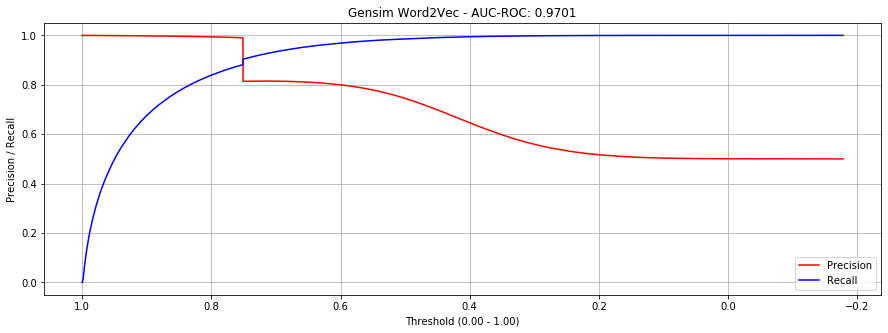

In [33]:
plot_auc(val['edge'], val['gensim_score'], 'Gensim Word2Vec - AUC-ROC: {:.4f}'.format(roc_score))

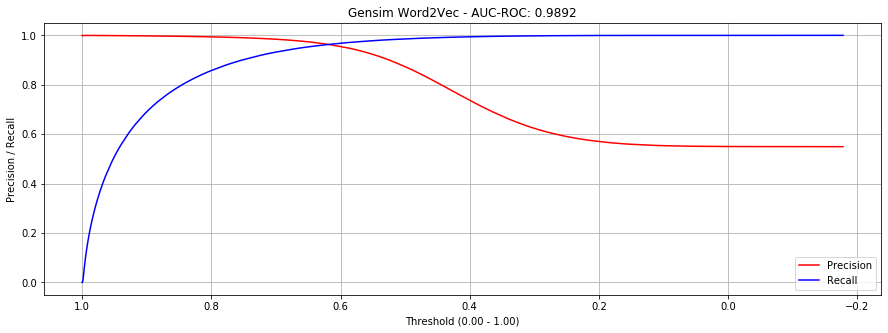

In [34]:
plot_auc(val_seen['edge'], val_seen['gensim_score'], 'Gensim Word2Vec - AUC-ROC: {:.4f}'.format(roc_score_seen))

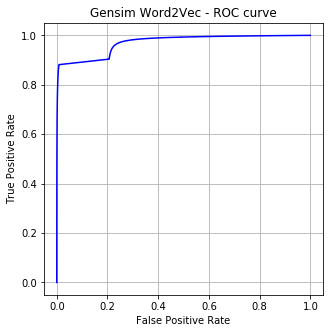

In [35]:
plot_roc(val['edge'], val['gensim_score'], 'Gensim Word2Vec - ROC curve')

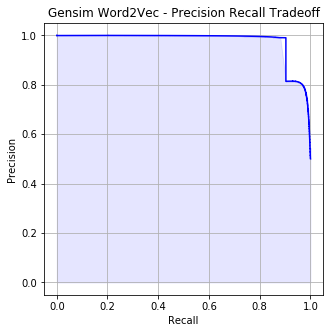

In [36]:
plot_tradeoff(val['edge'], val['gensim_score'], 'Gensim Word2Vec - Precision Recall Tradeoff')

In [37]:
kv = None

### 8. PyTorch word2vec (122.66 minutes)

In [38]:
word2id_torch_emb = load_model('../results/word2id_torch_w2v_{}'.format(dset))
func = get_product_id(word2id_torch_emb)
word2id_func = np.vectorize(func)

2019-12-18 09:28:28,814 - Model loaded from: ../results/word2id_torch_w2v_books (Size: 253394362 bytes)


In [39]:
skipgram = SkipGram(len(word2id_torch_emb), 128)
skipgram.load_state_dict(torch.load('../results/skipgram_epoch_4_2019-12-13-0954.pt', 
                                    map_location=torch.device('cpu')))

<All keys matched successfully>

In [40]:
w2v = skipgram.center_embeddings.weight.cpu().data.numpy()

In [41]:
val['product1id_w2v'] = word2id_func(val['product1'].values)
val['product2id_w2v'] = word2id_func(val['product2'].values)

In [42]:
def calculate_cosine_similarity2_vectorized(product1id, product2id):
    return np.inner(w2v[product1id], w2v[product2id]) / (np.linalg.norm(w2v[product1id]) * np.linalg.norm(w2v[product2id]))
    
cos_sim_func = np.vectorize(calculate_cosine_similarity2_vectorized)

In [43]:
val['w2v_score'] = cos_sim_func(val['product1id_w2v'].values, val['product2id_w2v'].values)

In [44]:
roc_score = roc_auc_score(val['edge'], val['w2v_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-18 09:33:10,284 - AUC-ROC: 0.9774652933586574


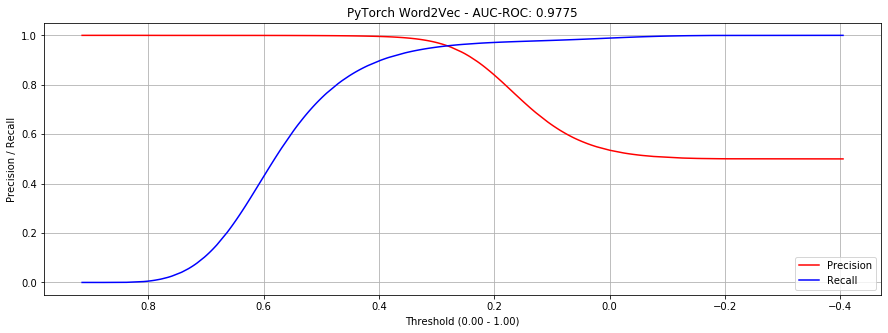

In [45]:
plot_auc(val['edge'], val['w2v_score'], 'PyTorch Word2Vec - AUC-ROC: {:.4f}'.format(roc_score))

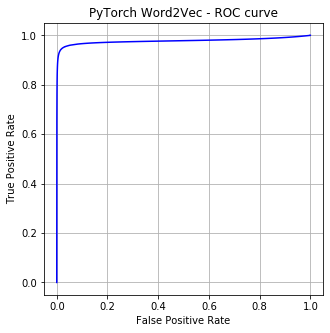

In [46]:
plot_roc(val['edge'], val['w2v_score'], 'PyTorch Word2Vec - ROC curve')

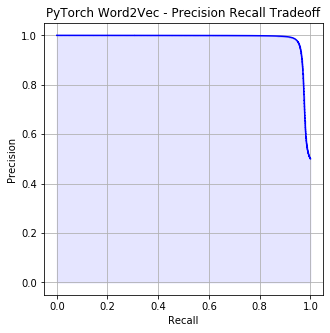

In [47]:
plot_tradeoff(val['edge'], val['w2v_score'], 'PyTorch Word2Vec - Precision Recall Tradeoff')

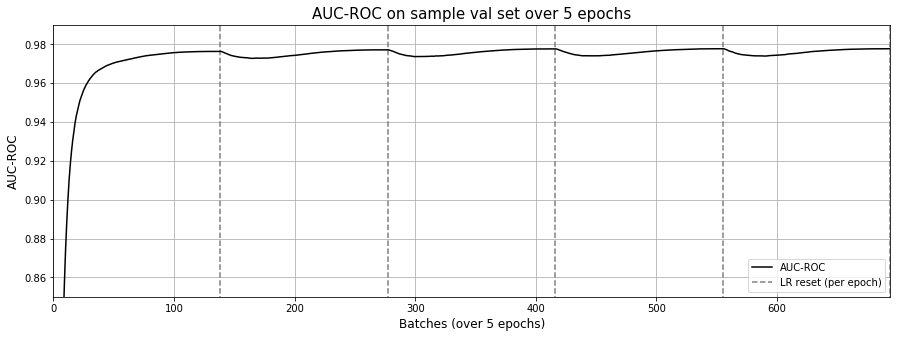

In [59]:
# Import and plot metrics
w2v_df = pd.read_csv('../results/model_metrics_w2v_books.csv')
plot_metrics(w2v_df, ylim=(0.85, 0.99))

In [49]:
word2id_torch_emb = None
skipgram = None

### 11. PyTorch MF-bias (1393.08 minutes)

In [50]:
word2id_torch_mf_bias = load_model('../results/word2id_torch_mf_bias_{}'.format(dset))
func = get_product_id(word2id_torch_mf_bias)
word2id_func = np.vectorize(func)

2019-12-18 09:33:47,396 - Model loaded from: ../results/word2id_torch_mf_bias_books (Size: 253394362 bytes)


In [51]:
mf_bias = MFBias(len(word2id_torch_mf_bias), 128)
mf_bias.load_state_dict(torch.load('../results/mf_bias_epoch_4_2019-12-14-0918.pt', map_location=torch.device('cpu')))

2019-12-18 09:33:49,238 - Model initialized: MFBias(
  (product_embedding): Embedding(1948370, 128)
  (sig): Sigmoid()
  (product_bias): Embedding(1948370, 1)
  (bce): BCELoss()
)


<All keys matched successfully>

In [52]:
val['product1id_mf_bias'] = word2id_func(val['product1'].values)
val['product2id_mf_bias'] = word2id_func(val['product2'].values)

In [53]:
product1 = torch.LongTensor(val['product1id_mf_bias'])
product2 = torch.LongTensor(val['product2id_mf_bias'])
with torch.no_grad():
    val['mf_bias_score'] = mf_bias.forward(product1, product2)

In [54]:
roc_score = roc_auc_score(val['edge'], val['mf_bias_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-18 09:36:54,570 - AUC-ROC: 0.7195599968239217


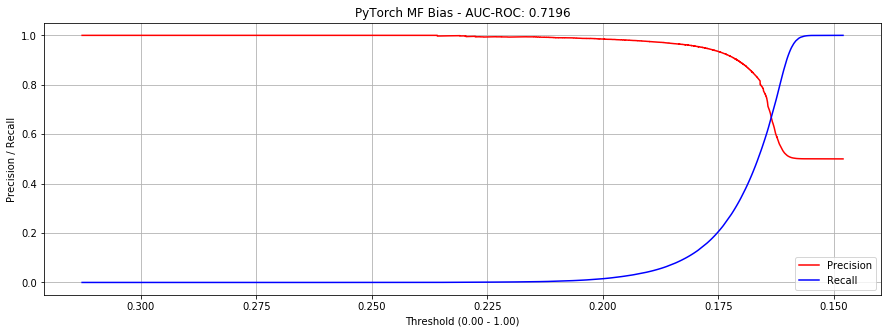

In [55]:
plot_auc(val['edge'], val['mf_bias_score'], 'PyTorch MF Bias - AUC-ROC: {:.4f}'.format(roc_score))

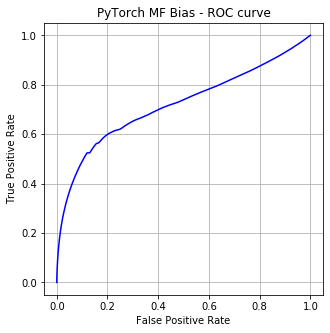

In [56]:
plot_roc(val['edge'], val['mf_bias_score'], 'PyTorch MF Bias - ROC curve')

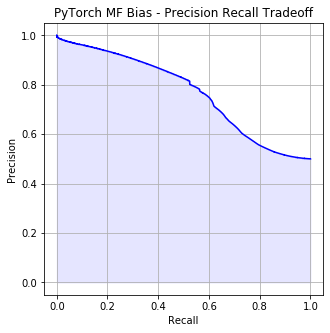

In [57]:
plot_tradeoff(val['edge'], val['mf_bias_score'], 'PyTorch MF Bias - Precision Recall Tradeoff')

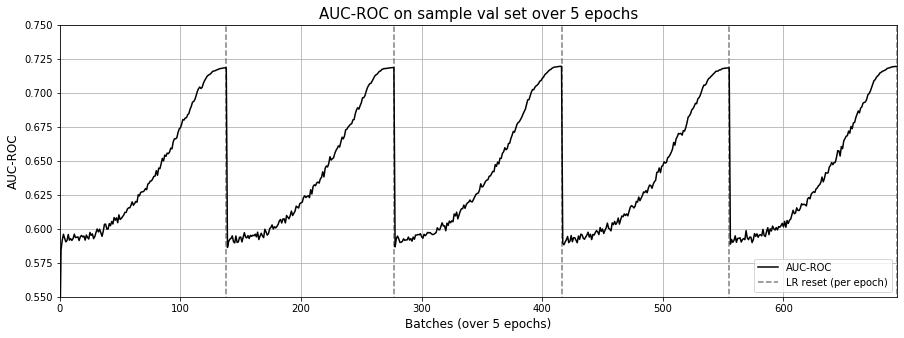

In [58]:
# Import and plot metrics
mf_bias_df = pd.read_csv('../results/model_metrics_mf_bias_books.csv')
plot_metrics(mf_bias_df, ylim=(0.55, 0.75))